## Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use theppds to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between nodeppds and data generated by `world_dist`.

In [2]:
import matplotlib as mpl  # for colour maps
import matplotlib.pyplot as plt  # because Figures >> Text
import numpy as np  # ...of course we need numpy

# import pandas as pd  # for seaborn, I guess
import palettable as pt  # nicer color pallettes
import pickle  # output export/import
import scipy

# import seaborn as sns  # for pretty plots

In [3]:
cmap = pt.scientific.sequential.Tokyo_4_r.get_mpl_colormap()
cmap2 = mpl.colormaps["magma"]

#### 2024-03 Run 0 

Distance (KLD, lin., quad.), given
1. $(r,h)\in\{ (1,1),(0.1,5),(5,0.1)\}$
2. $N_{nodes}\in 1e(1,1.5,2,2.5,3,3.5,4)$

In [4]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/2024-03--Run0/"

# 1.) (r,h) data
rates = [(0.1, 5), (5, 0.1), (1, 1)]
N_arr = [int(10**N) for N in np.arange(1, 4.5, 0.5)]

res2 = []
t_exec_arr = []
mu_arr = []
kld_arr = []
dist_arr = []


for N in N_arr:
    for i in rates:
        if i[0] == 1 and i[1] == 1:
            filename = "out--N_nodes-" + str(N) + "--t_max-100.pkl"
        else:
            filename = (
                "out--N_nodes-"
                + str(N)
                + "--r-"
                + str(i[0])
                + "--h-"
                + str(i[1])
                + ".pkl"
            )
        with open(data_dir + filename, "rb") as export:
            res2.append(filename)
            output = pickle.load(export)
            t_exec_arr.append(output["t_exec"])
            mu_arr.append(output["mu_nodes"])
            kld_arr.append(output["kl_divs"])
            dist_arr.append(output["p_distances"])


np.array(res2).reshape(len(N_arr), len(rates))

array([['out--N_nodes-10--r-0.1--h-5.pkl',
        'out--N_nodes-10--r-5--h-0.1.pkl',
        'out--N_nodes-10--t_max-100.pkl'],
       ['out--N_nodes-31--r-0.1--h-5.pkl',
        'out--N_nodes-31--r-5--h-0.1.pkl',
        'out--N_nodes-31--t_max-100.pkl'],
       ['out--N_nodes-100--r-0.1--h-5.pkl',
        'out--N_nodes-100--r-5--h-0.1.pkl',
        'out--N_nodes-100--t_max-100.pkl'],
       ['out--N_nodes-316--r-0.1--h-5.pkl',
        'out--N_nodes-316--r-5--h-0.1.pkl',
        'out--N_nodes-316--t_max-100.pkl'],
       ['out--N_nodes-1000--r-0.1--h-5.pkl',
        'out--N_nodes-1000--r-5--h-0.1.pkl',
        'out--N_nodes-1000--t_max-100.pkl'],
       ['out--N_nodes-3162--r-0.1--h-5.pkl',
        'out--N_nodes-3162--r-5--h-0.1.pkl',
        'out--N_nodes-3162--t_max-100.pkl'],
       ['out--N_nodes-10000--r-0.1--h-5.pkl',
        'out--N_nodes-10000--r-5--h-0.1.pkl',
        'out--N_nodes-10000--t_max-100.pkl']], dtype='<U34')

In [24]:
# MLE-t plots

N_ex = [1, 3, 5]
# N_equiv = [31, 316, 3162]
rates_ex = [0, 1]  # ==[(0.1, 5), (5, 0.1)], because I seemingly like ugly coding
rates_equiv = [(0.1, 5), (5, 0.1)]

fig, ax = plt.subplots(
    len(rates_ex),
    len(N_ex),
    figsize=(1.5 * 3 * len(rates_ex), 1 * len(N_ex)),
    constrained_layout=True,
)

plotted = []
for i, _ in enumerate(N_ex):
    for j in rates_ex:
        idx = N_ex[i] * 3 + j
        plotted.append(res2[idx])
        mu_tmp = np.array(mu_arr[idx]).T
        for y in mu_tmp:
            x = np.arange(0, len(y) * 2.5, 2.5)
            ax[j, i].plot(x, y, alpha=0.2)
        ax[j, i].set_title("N=" + str(len(mu_tmp)) + "; (r,h)=" + str(rates_equiv[j]))
print(plotted)
ax[0, 0].set_ylabel("$MLE(\mu)_i$")
ax[1, 0].set_ylabel("$MLE(\mu)_i$")
ax[1, 0].set_xlabel("$t$")
ax[1, 1].set_xlabel("$t$")
ax[1, 2].set_xlabel("$t$")
fig.suptitle(
    "Maximum likelihood estimates (MLEs) of each node $i$ over time $t$, given\n different network size $N$, mean degree 3 and node/world communication rates $r$/$h$"
)

plt.show()
fig.savefig("MLEs.png", dpi=600)

['out--N_nodes-31--r-0.1--h-5.pkl', 'out--N_nodes-31--r-5--h-0.1.pkl', 'out--N_nodes-316--r-0.1--h-5.pkl', 'out--N_nodes-316--r-5--h-0.1.pkl', 'out--N_nodes-3162--r-0.1--h-5.pkl', 'out--N_nodes-3162--r-5--h-0.1.pkl']


/tmp/ipykernel_105565/1764770040.py:16: RuntimeWarning: Mean of empty slice
  kld_mean.append(np.nanmean(np.array(kld_arr[idx]), axis=1)[:, 1])


['out--N_nodes-31--r-0.1--h-5.pkl', 'out--N_nodes-31--r-5--h-0.1.pkl', 'out--N_nodes-316--r-0.1--h-5.pkl', 'out--N_nodes-316--r-5--h-0.1.pkl', 'out--N_nodes-3162--r-0.1--h-5.pkl', 'out--N_nodes-3162--r-5--h-0.1.pkl']


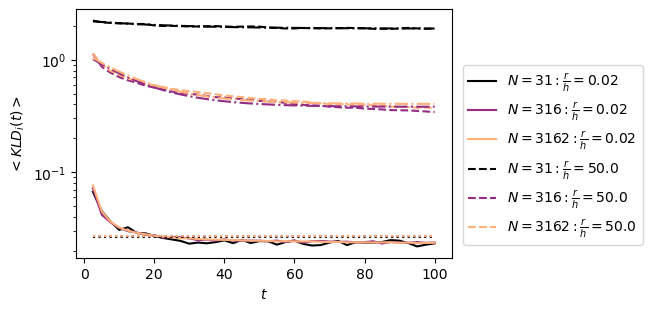

In [102]:
# <KLD>-t plots
N_ex = [1, 3, 5]
N_equiv = [31, 316, 3162]
rates_ex = [0, 1]  # ==[(0.1, 5), (5, 0.1)], because I seemingly like ugly coding
rates = [0.1 / 5, 5 / 0.1]

kld_mean = []
labels = []
plotted = []
for i, _ in enumerate(N_ex):
    for j in rates_ex:
        idx = N_ex[i] * 3 + j
        labels.append(
            "$N=" + str(N_equiv[i]) + ": \\" + "frac{r}{h}=" + str(rates[j]) + "$"
        )
        kld_mean.append(np.nanmean(np.array(kld_arr[idx]), axis=1)[:, 1])
        plotted.append(res2[idx])
print(plotted)
x = np.arange(0, len(kld_mean[0]) * 2.5, 2.5)

x = x[1:]
kld_mean = np.array(kld_mean)[:, 1:]

pfac = 3

fig = plt.figure(
    figsize=(1.5 * pfac, 1 * pfac),
    constrained_layout=True,
)
ax = fig.add_subplot(111)
ax.set_prop_cycle(
    color=cmap2(np.linspace(0, 1 - 1 / len(kld_mean), len(kld_mean) // 2))
)

for i in [0, 2, 4]:
    ax.plot(x, kld_mean[i], linestyle="-", label=str(labels[i]))

for i in [1, 3, 5]:
    ax.plot(x, kld_mean[i], linestyle="--", label=str(labels[i]))


# fitting
def func(x, a, b, c):
    return a * np.exp(b * x) + c


x = x
y = kld_mean
fits_r = []
for y in np.array(kld_mean)[[0, 2, 4]]:
    fits_r.append(
        scipy.optimize.curve_fit(
            func, x, y, bounds=([0, -np.inf, 0], [np.inf, 0, np.inf])
        )
    )
fits_h = []
for y in np.array(kld_mean)[[1, 3, 5]]:
    fits_h.append(
        scipy.optimize.curve_fit(
            func, x, y, bounds=([0, -np.inf, 0], [np.inf, 0, np.inf])
        )
    )
for i in fits_r:
    ax.plot(x, func(x, *i[0]), linestyle=":")
for i in fits_h:
    ax.plot(x, func(x, *i[0]), linestyle="-.")

# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$t$")
ax.set_ylabel("$<KLD_i(t)>$")

fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))

#### Figure 2

Run w. order-of-magnitude rate differences.


In [ ]:
data_dir = "../tests/2024-03--Run2-OOMrates-SmallPrior/"

# construct array of file name parts
N_arr = np.arange(1.5, 4, 1)
r_arr = [0.1, 1, 10]
prior_arr = ["uniform", "small"]

files = []
t_exec_arr = []
mu_arr = []
kld_arr = []
d_arr = []

for prior in prior_arr:
    for N in N_arr:
        for r in r_arr:
            filename = (
                "out--N-"
                + str(N)
                + "--r-"
                + str(r)
                + "--"
                + str(prior)
                + "-prior"
                + ".pkl"
            )
            "out--N-1.5--r-0.1--small-prior.pkl"
            
            with open(data_dir + filename, "rb") as export:
                files.append(filename)
                output = pickle.load(export)
                t_exec_arr.append(output["t_exec"])
                mu_arr.append(output["mu_nodes"])
                kld_arr.append(output["kl_divs"])
                d_arr.append(output["p_distances"])

?^@cg3??88

files

['out--N-1.5--r-0.1--uniform-prior.pkl',
 'out--N-1.5--r-1--uniform-prior.pkl',
 'out--N-1.5--r-10--uniform-prior.pkl',
 'out--N-2.5--r-0.1--uniform-prior.pkl',
 'out--N-2.5--r-1--uniform-prior.pkl',
 'out--N-2.5--r-10--uniform-prior.pkl',
 'out--N-3.5--r-0.1--uniform-prior.pkl',
 'out--N-3.5--r-1--uniform-prior.pkl',
 'out--N-3.5--r-10--uniform-prior.pkl',
 'out--N-1.5--r-0.1--small-prior.pkl',
 'out--N-1.5--r-1--small-prior.pkl',
 'out--N-1.5--r-10--small-prior.pkl',
 'out--N-2.5--r-0.1--small-prior.pkl',
 'out--N-2.5--r-1--small-prior.pkl',
 'out--N-2.5--r-10--small-prior.pkl',
 'out--N-3.5--r-0.1--small-prior.pkl',
 'out--N-3.5--r-1--small-prior.pkl',
 'out--N-3.5--r-10--small-prior.pkl']

In [ ]:
idx_unif = []
for i, _ in enumerate(N_arr):
    for j, _ in enumerate(r_arr):
        k = i * len(r_arr) + j
        print(k, " -- ", files[k])
        idx_unif.append(k)
idx_unif = np.array(idx_unif).reshape(len(N_arr), len(r_arr)).T
idx_unif

0  --  out--N-1.5--r-0.1--uniform-prior.pkl
1  --  out--N-1.5--r-1--uniform-prior.pkl
2  --  out--N-1.5--r-10--uniform-prior.pkl
3  --  out--N-2.5--r-0.1--uniform-prior.pkl
4  --  out--N-2.5--r-1--uniform-prior.pkl
5  --  out--N-2.5--r-10--uniform-prior.pkl
6  --  out--N-3.5--r-0.1--uniform-prior.pkl
7  --  out--N-3.5--r-1--uniform-prior.pkl
8  --  out--N-3.5--r-10--uniform-prior.pkl


array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [ ]:
idx_small = []
for i, _ in enumerate(N_arr):
    for j, _ in enumerate(r_arr):
        k = i * len(r_arr) + j + 9
        print(k, " -- ", files[k])
        idx_small.append(k)
idx_small = np.array(idx_small).reshape(len(N_arr), len(r_arr)).T
idx_small

9  --  out--N-1.5--r-0.1--small-prior.pkl
10  --  out--N-1.5--r-1--small-prior.pkl
11  --  out--N-1.5--r-10--small-prior.pkl
12  --  out--N-2.5--r-0.1--small-prior.pkl
13  --  out--N-2.5--r-1--small-prior.pkl
14  --  out--N-2.5--r-10--small-prior.pkl
15  --  out--N-3.5--r-0.1--small-prior.pkl
16  --  out--N-3.5--r-1--small-prior.pkl
17  --  out--N-3.5--r-10--small-prior.pkl


array([[ 9, 12, 15],
       [10, 13, 16],
       [11, 14, 17]])

In [ ]:
# MLE-t plots (degree 11, uniform prior)

N_ex = N_arr  # N_equiv = [31, 316, 3162]
rates_ex = r_arr  # rates_equiv = [0.1, 1, 10]

scal = 2
fig, ax = plt.subplots(
    len(rates_ex),
    len(N_ex),
    figsize=(1.5 * scal * len(rates_ex), 1 * scal * len(N_ex)),
    constrained_layout=True,
)
for i, _ in enumerate(N_ex):
    for j, _ in enumerate(rates_ex):
        k = i * len(rates_ex) + j
        print(files[k])
        mu_tmp = np.array(mu_arr[k]).T
        for y in mu_tmp:
            x = np.arange(0, len(y) * 2.5, 2.5)
            ax[j, i].plot(x, y, alpha=0.2)
        ax[j, i].set_title("N=" + str(len(mu_tmp)) + "; r=" + str(rates_ex[j]))

for i, _ in enumerate(rates_ex):
    ax[i, 0].set_ylabel("$MLE(\mu)_i$")
for j, _ in enumerate(N_ex):
    ax[-1, j].set_xlabel("$t$")

fig.suptitle(
    "Maximum likelihood estimates (MLEs) of each node $i$ over time $t$, given:\n $N$ nodes (degree 11), communication rate $r$, uniform prior"
)

plt.show()
# fig.savefig("MLEs.png")

out--N-1.5--r-0.1--uniform-prior.pkl
out--N-1.5--r-1--uniform-prior.pkl
out--N-1.5--r-10--uniform-prior.pkl
out--N-2.5--r-0.1--uniform-prior.pkl
out--N-2.5--r-1--uniform-prior.pkl
out--N-2.5--r-10--uniform-prior.pkl
out--N-3.5--r-0.1--uniform-prior.pkl
out--N-3.5--r-1--uniform-prior.pkl
out--N-3.5--r-10--uniform-prior.pkl


out--N-1.5--r-0.1--small-prior.pkl
out--N-1.5--r-1--small-prior.pkl
out--N-1.5--r-10--small-prior.pkl
out--N-2.5--r-0.1--small-prior.pkl
out--N-2.5--r-1--small-prior.pkl
out--N-2.5--r-10--small-prior.pkl
out--N-3.5--r-0.1--small-prior.pkl
out--N-3.5--r-1--small-prior.pkl
out--N-3.5--r-10--small-prior.pkl


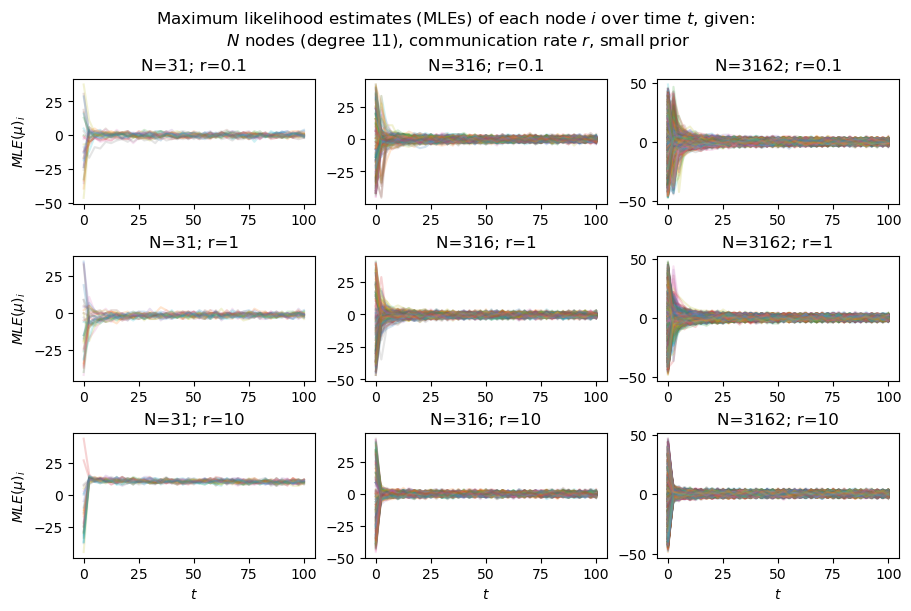

In [ ]:
# MLE-t, degree 11, small prior

N_ex = N_arr  # N_equiv = [31, 316, 3162]
rates_ex = r_arr  # rates_equiv = [0.1, 1, 10]

scal = 2
fig, ax = plt.subplots(
    len(rates_ex),
    len(N_ex),
    figsize=(1.5 * scal * len(rates_ex), 1 * scal * len(N_ex)),
    constrained_layout=True,
)
# fig.tight_layout()

for i, _ in enumerate(N_ex):
    for j, _ in enumerate(rates_ex):
        k = i * len(rates_ex) + j + 9
        print(files[k])
        mu_tmp = np.array(mu_arr[k]).T
        for y in mu_tmp:
            x = np.arange(0, len(y) * 2.5, 2.5)
            ax[j, i].plot(x, y, alpha=0.2)
        ax[j, i].set_title("N=" + str(len(mu_tmp)) + "; r=" + str(rates_ex[j]))
ax[0, 0].set_ylabel("$MLE(\mu)_i$")
ax[1, 0].set_ylabel("$MLE(\mu)_i$")
ax[2, 0].set_ylabel("$MLE(\mu)_i$")
ax[2, 0].set_xlabel("$t$")
ax[2, 1].set_xlabel("$t$")
ax[2, 2].set_xlabel("$t$")

fig.suptitle(
    "Maximum likelihood estimates (MLEs) of each node $i$ over time $t$, given:\n $N$ nodes (degree 11), communication rate $r$, small prior"
)

plt.show()
# fig.savefig("MLEs.png")

In [ ]:
np.array(kld_arr[2]).shape

(41, 31, 2)